# The Data Incubator Proposal
# [UPDATED November 2017 for Interview]
## Phillip Yen

### I plan to develop a career exploration tool that helps job seekers find job listings that are most appropriate to apply to based on the skills listed on their resume.

### In the following program, I have implemented a prototype tool that scrapes job listings from Indeed.com and keywords from Stack Exchange to show which skills are the most desired for particular jobs search terms. The three search terms I decided to test the program on were "bioinformatics", "data science", and "data mining".

## Over 500 jobs listings from Indeed.com  scraped each query (bioinformatics, data science, and data mining) 
<img src="indeed_scrape.png">

## Over 600 tags (keywords) scraped Stack Exchange's Bioinformatics and Data Science sites 
<img src="tags_scrape.png">

In [3]:
%matplotlib inline
import urllib
from urllib.request import urlopen as uReq
from urllib.error import URLError, HTTPError
from bs4 import BeautifulSoup as soup
from bs4.element import Comment
import pandas as pd
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import ssl
import numpy as np
from random import shuffle
from sklearn.metrics import jaccard_similarity_score
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as sch


import nltk
from nltk.book import *
from nltk import bigrams
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.corpus import words

matplotlib.rcParams['figure.figsize'] = 8,8

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [ ]:
##################
# Scrape the URLs
##################
df_bioinf, s_bioinf = scrape_indeed('bioinformatics')
df_datasci, s_datasci = scrape_indeed('data science')
df_datamin, s_datamin = scrape_indeed('data mining')

In [8]:
######################################################################################
# example of a scraped link. Would need to start full link with http://www.indeed.com
# and then append the scraped link
######################################################################################

df_bioinf['ext_link'][5]

test_link = 'http://www.indeed.com'+df_bioinf['ext_link'][5]
html = uReq(test_link).read()
raw_text = ' '.join(text_from_html(html).split())
#print(raw_text)

# Testing the scrape_and_dump_listings function
scrape_and_dump_listings(urls=df_bioinf["ext_link"][:10],name="bioinfs_test")

'/rc/clk?jk=ad15d944bf49f67f&fccid=8765a4045377753a'

In [ ]:
########################################################################
# Approximately 500 jobs were scraped for each of the three search terms
# Don't actually run again unless you want to rescrape all the listings
########################################################################
scrape_and_dump_listings(urls=df_bioinf["ext_link"],name="bioinformatics")
scrape_and_dump_listings(urls=df_datasci["ext_link"],name="datascience")
scrape_and_dump_listings(urls=df_datamin["ext_link"],name="datamining")

In [6]:
##############################################
# scrape the tags from the bioinformatics and
# data science stackoverflow sites
##############################################

tags_bioinf = scrape_stackoverflow()
tags_bioinf = sorted(tags_bioinf)

tags_datasci = scrape_stackoverflow("datascience",10)
tags_datasci = sorted(tags_datasci)

# Merge the tags from the bioinformatics and data science stackoverflow pages
tags_merged = list(set(tags_bioinf+tags_datasci))

In [11]:
##############################################
# count the overall number of times each tag
# appears in the compiled scraped job listings
##############################################

tag_count_bioinf = count_tag_freq("bioinformatics_text_dump.txt",tags_merged)
tag_count_datasci = count_tag_freq("datascience_text_dump.txt",tags_merged)
tag_count_datamin = count_tag_freq("datamining_text_dump.txt",tags_merged)

# Fig 1a. Frequency of of tags in Bioinformatics Jobs

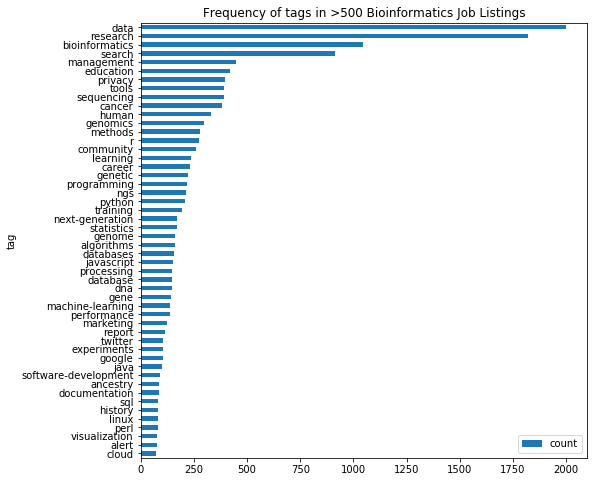

In [12]:
df_bioinf_tag_counts = pd.DataFrame({"tag": tags_merged, "count": tag_count_bioinf}, columns = ["tag","count"])
(df_bioinf_tag_counts
    .sort_values("count",ascending=False)
    .head(50)
    .plot(kind="barh",x="tag",title="Frequency of tags in >500 Bioinformatics Job Listings"))
plt.gca().invert_yaxis()

# Fig 1b. Frequency of tags in Data Science Jobs

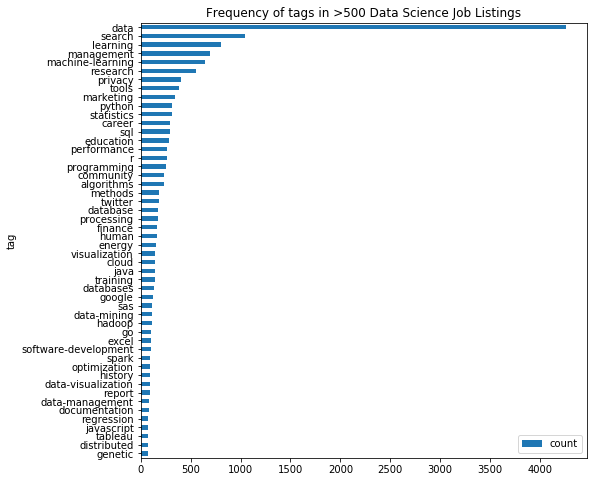

In [13]:
df_datasci_tag_counts = pd.DataFrame({"tag": tags_merged, "count": tag_count_datasci}, columns = ["tag","count"])
(df_datasci_tag_counts
    .sort_values("count",ascending=False)
    .head(50)
    .plot(kind="barh",x="tag",title="Frequency of tags in >500 Data Science Job Listings"))
plt.gca().invert_yaxis()

# Fig 1c. Frequency of tags in Data Mining Jobs

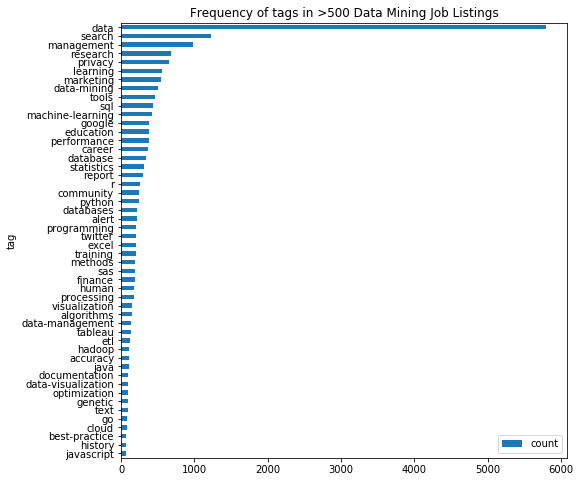

In [14]:
df_datamin_tag_counts = pd.DataFrame({"tag": tags_merged, "count": tag_count_datamin}, columns = ["tag","count"])
(df_datamin_tag_counts
    .sort_values("count",ascending=False)
    .head(50)
    .plot(kind="barh",x="tag",title="Frequency of tags in >500 Data Mining Job Listings"))
plt.gca().invert_yaxis()

In [15]:
with open("bioinformatics_text_dump.txt",encoding='utf-8') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content_bioinf = [x.strip() for x in content]

tags_top50 = (df_bioinf_tag_counts
    .sort_values("count",ascending=False)
    .head(50))["tag"]

df_tags_in_listings_bioinf, coocc_bioinf = create_tags_in_listings_df(tags_top50,content_bioinf)


# Fig 2a. Co-occurrence of  pairs of tags in bioinformatics job listings

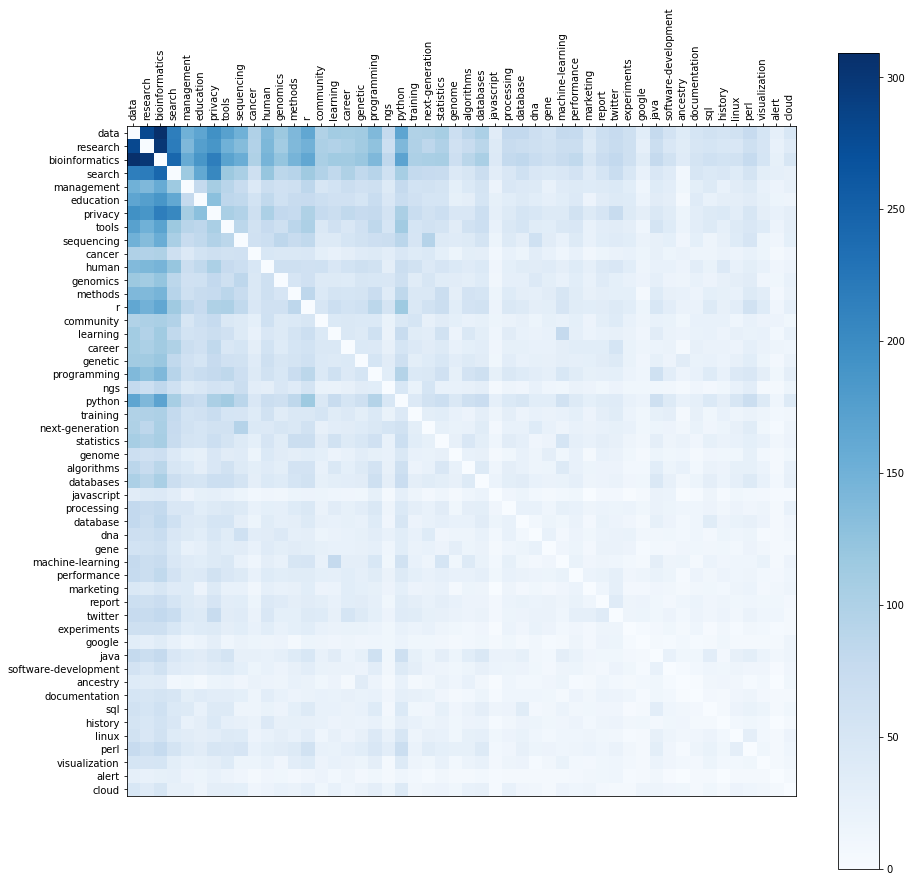

In [16]:
plt.figure(figsize=(15,15))
plt.imshow(coocc_bioinf,interpolation='nearest', cmap='Blues')
plt.xticks(range(len(tags_top50)), tags_top50, rotation='vertical')
plt.gca().tick_params(top='on',bottom='off',labeltop='on',labelbottom='off')
plt.yticks(range(len(tags_top50)), tags_top50, rotation='horizontal')
plt.colorbar()
plt.show()

In [83]:
with open("curated_tags.txt",encoding='utf-8') as f:
    curated_tags = f.readlines()
    
curated_tags = [x.strip() for x in curated_tags]
shuffle(curated_tags)

df_tags_curated, coocc_curated = create_tags_in_listings_df(curated_tags,content_bioinf)

# Fig 2b. Co-occurrence of  pairs of *manually curated* subset tags in job listings

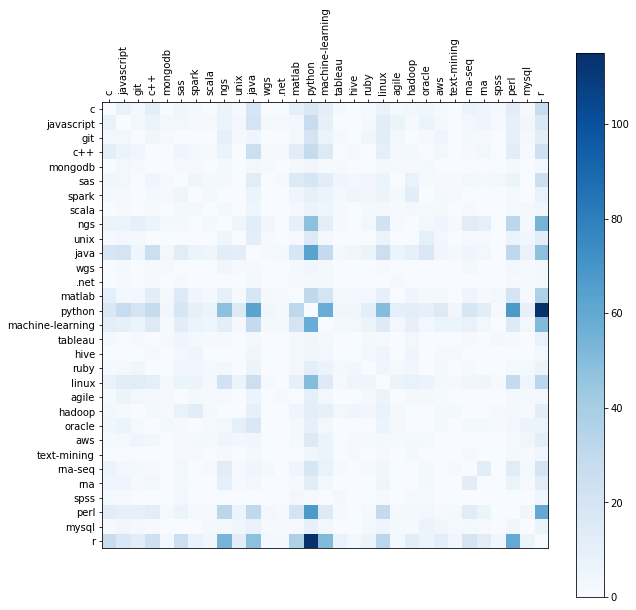

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(coocc_curated,interpolation='nearest', cmap='Blues')
plt.xticks(range(len(curated_tags)), curated_tags, rotation='vertical')
plt.gca().tick_params(top='on',bottom='off',labeltop='on',labelbottom='off')
plt.yticks(range(len(curated_tags)), curated_tags, rotation='horizontal')
plt.colorbar()
plt.show()

In [96]:
with open("curated_tags.txt",encoding='utf-8') as f:
    curated_tags = f.readlines()
    
curated_tags = [x.strip() for x in curated_tags]
curated_tags.remove('python')
curated_tags.remove('r')
shuffle(curated_tags)

df_tags_curated, coocc_curated = create_tags_in_listings_df(curated_tags,content_bioinf)

# Fig 2b. Co-occurrence of  pairs of *manually curated* subset tags in job listings *excluding Python and R*

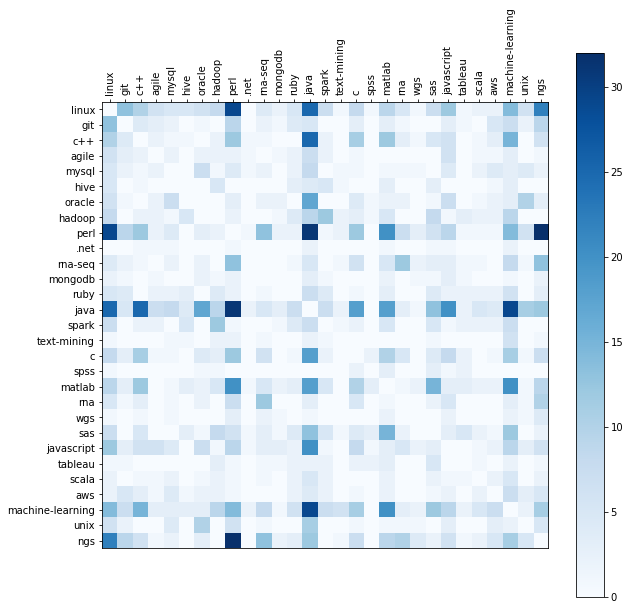

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(coocc_curated,interpolation='nearest', cmap='Blues')
plt.xticks(range(len(curated_tags)), curated_tags, rotation='vertical')
plt.gca().tick_params(top='on',bottom='off',labeltop='on',labelbottom='off')
plt.yticks(range(len(curated_tags)), curated_tags, rotation='horizontal')
plt.colorbar()
plt.show()

In [19]:
thefile = open('tags_merged.txt', 'w')
for item in tags_merged:
    thefile.write("%s\n" % item)

thefile.close()

In [56]:
df_tags_in_listings_bioinf_complete, coocc_bioinf_complete = create_tags_in_listings_df(tags_merged,content_bioinf)
df_tags_in_listings_bioinf_complete.to_csv('df_tags_in_listings_bioinf_complete.csv')
df_tags_in_listings_bioinf_complete = pd.read_csv('df_tags_in_listings_bioinf_complete.csv',index_col=0,header=0)

In [57]:
#####################################################################
# Calculate the Jaccard distances between the 500 Bioinformatics jobs
#####################################################################

pairwise_distance = pd.DataFrame(distance.squareform(distance.pdist(df_tags_in_listings_bioinf_complete,metric="jaccard")))
pairwise_distance -= 1
pairwise_distance *= -1
pairwise_distance = pairwise_distance.fillna(0)

#plt.figure(figsize=(20,20))
#plt.imshow(pairwise_distance,interpolation='nearest', cmap='Blues')
#plt.show()
#pairwise_distance


# Fig 3a. Visualization of presence of tags (columns) in the job listings (rows)

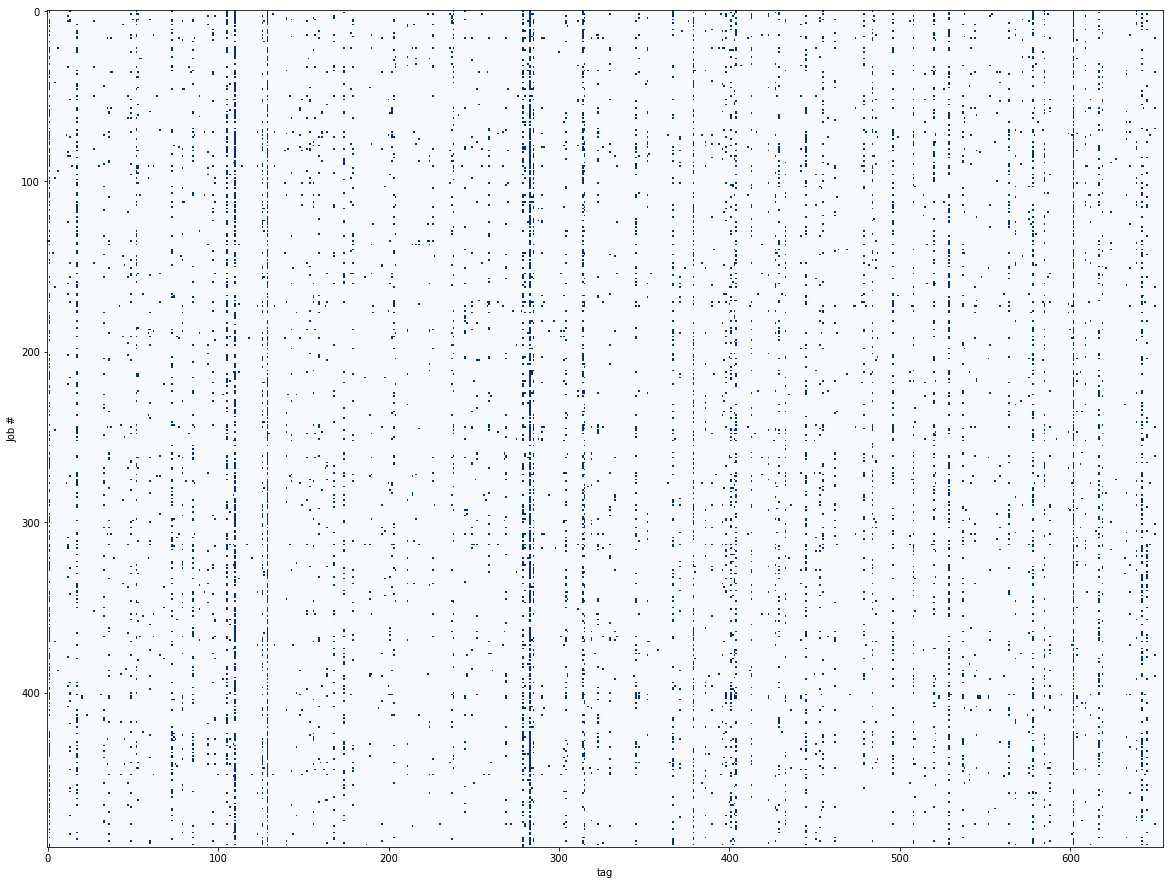

In [60]:
plt.figure(figsize=(20,20))
plt.imshow(df_tags_in_listings_bioinf_complete,interpolation='nearest', cmap='Blues')
plt.ylabel("Job #")
plt.xlabel("tag")
plt.show()

# Fig 3b. *Clustered* Visualization of presence of tags (columns) in the job listings (rows)


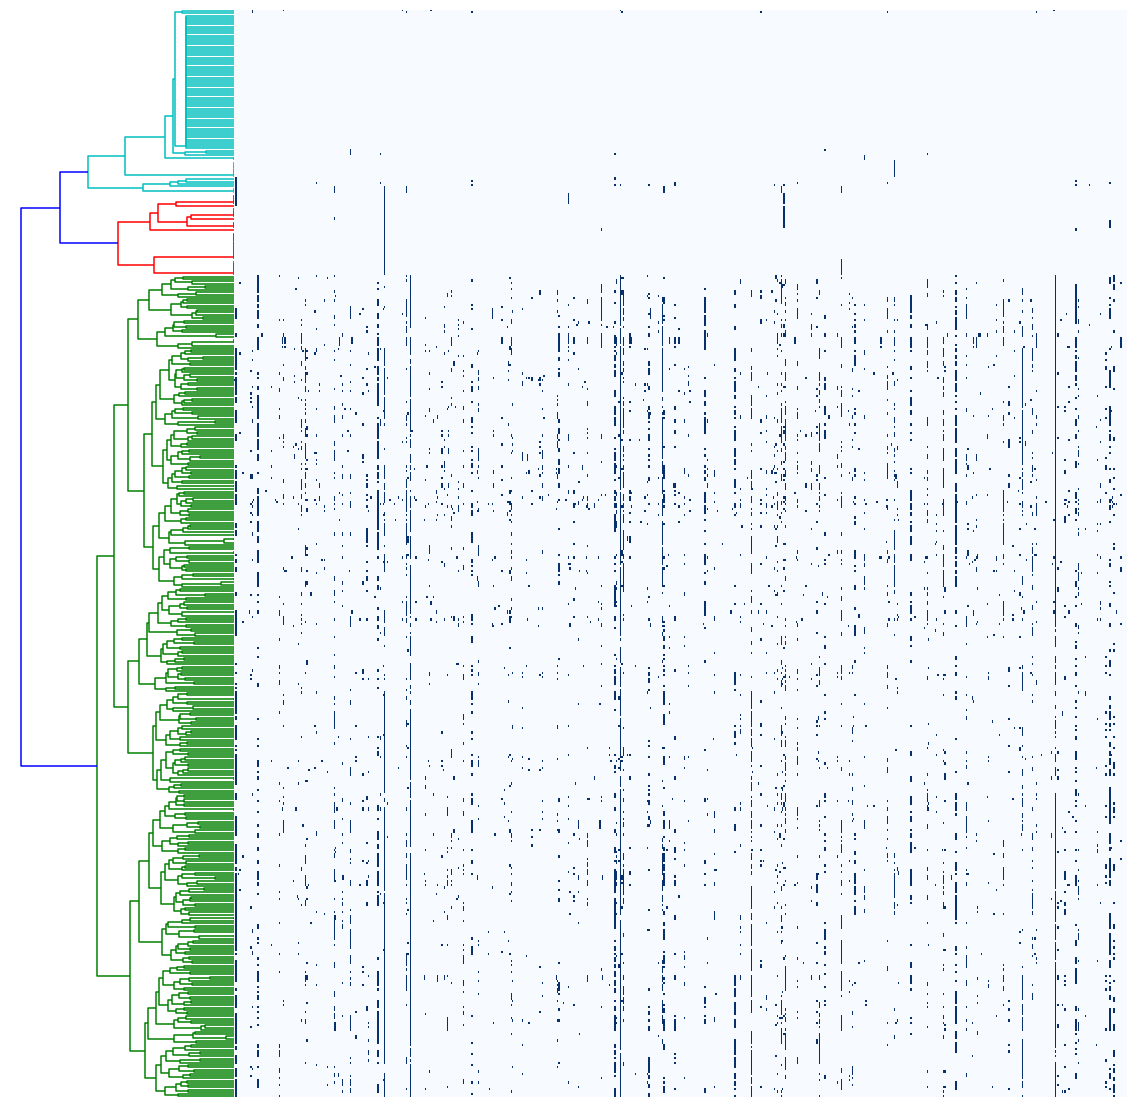

In [66]:
clusters = sch.linkage(pairwise_distance.as_matrix(),method='complete')

fig = plt.figure(figsize=(20,20))
heatmapGS = gridspec.GridSpec(1,2,wspace=0.0,hspace=0.0,width_ratios=[0.25,1])

### row dendrogram ###
denAX = fig.add_subplot(heatmapGS[0,0])
denD = sch.dendrogram(clusters,orientation='left')
clean_axis(denAX)

### heatmap ###
heatmapAX = fig.add_subplot(heatmapGS[0,1])
axi = heatmapAX.imshow(df_tags_in_listings_bioinf_complete.ix[den['leaves']],interpolation='nearest',aspect='auto',origin='lower',cmap="Blues")
clean_axis(heatmapAX)

## Conclusion

### I hope to continue analyzing these results to which subset of keywords characterize each cluster of jobs to get a sense of the classes of bioinformatics jobs that exist. This is could then be used as a search engine to find job listings that match most to one's skill sets.

### Functions

In [ ]:
def scrape_indeed(k):
    keyword = k.replace(" ", "+")
    base_url = "https://www.indeed.com/jobs?q=" + keyword + "&start="
    urls = []
#    num = [x*10 for x in range(2)]
    num = [x*10 for x in range(51)]
    for i in num:
        urls.append(base_url + str(i))

    temp_names = []
    temp_experiences = []
    temp_ext_links = []
    
    for url in urls:
        uClient = uReq(url)
        page_html = uClient.read()
        uClient.close()
        page_soup = soup(page_html, "html.parser")
        containers = page_soup.findAll("div", {"class":"row"})
        for container in containers:
            experiences = container.findAll("span",{"class":"experienceList"})
            job_title = container.a["title"].strip()
            ext_link = container.a["href"]
            if len(experiences) > 0:
                temp_names.append(job_title)
                temp_experiences.append(experiences[0].text)
                temp_ext_links.append(ext_link)
            else:
                temp_names.append(job_title)
                temp_experiences.append("none_listed")
                temp_ext_links.append(ext_link)

    df = pd.DataFrame({'title': temp_names, 'experiences': temp_experiences, 'ext_link': temp_ext_links})
    cols = df.columns.tolist()
    cols = ['title','experiences','ext_link']
    df = df[cols]
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)

    experiences_dump = []
    for i in df["experiences"]:
        temp = i.split(",")
        for j in temp:
            experiences_dump.append(j.strip())

    s = pd.Series(experiences_dump)
    
    return df, s

#######################################################
# At least for the moment, the most important output
# is df["ext_link"], which are the links to the actual
# job listings scraped from Indeed.com
#######################################################


#######################
# deprecated function
#######################

def plot_skills(name,s):
    s_trunc = s.value_counts()
    s_trunc = s_trunc.iloc[0:50]
    plt.figure(figsize =(10,10))
    s_trunc.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.ylabel('skill')
    plt.xlabel('count')
    plt.title("Skills needed for %s jobs" % name)
    plt.show()

#######################################################################################
# functions for grabbing all visible text from a webpage using beautiful soup
# https://stackoverflow.com/questions/1936466/beautifulsoup-grab-visible-webpage-text
#######################################################################################

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    page_soup = soup(body, 'html.parser')
    texts = page_soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

########################################################################
# Function that takes in the list of URLs, scrapes the text from those
# sites, and then dumps the text into a text file
# For the "urls" parameter, pass df['ext_link'] as the argument.
########################################################################

def scrape_and_dump_listings(urls,name="bioinformatics"):
    f = open(name+'_text_dump.txt', 'w', encoding='utf-8')

    #https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error
    context = ssl._create_unverified_context()

    for idx, val in enumerate(urls):
        link = 'http://www.indeed.com'+val

        try:
            req = urllib.request.Request(link, headers={'User-Agent' : "Magic Browser"})     
            html = uReq(req,context=context, timeout=10).read()
            
        # skip over any sites that cause errors during scraping
        except (HTTPError, ConnectionResetError, URLError):
            print(idx," of ",len(urls), "(",round(idx/len(urls)*100,2),"%)")
            print("Something bad happened")
            continue
            
        except Exception:
            print("Timeout error")
            continue

        else:
            raw_text = ' '.join(text_from_html(html).split())
            #print(idx,link)
            print(idx+1," of ",len(urls), "(",round((idx+1)/len(urls)*100,2),"%)")
            #print(raw_text,'\n')
            f.write(str(idx)+link)
            f.write(raw_text+'\n')

    f.close()
    
    print("Scraped listings have been dumped in: "+name+'_text_dump.txt')

#############################################################
# Function that scrapes the keywords tags from stackoverflow
# Currently, the arguments can be k="bioinformatics" with
# num_pages=9, or k="datascience" with num_pages=10. Returns
# a list of strings of the tags.
#############################################################

def scrape_stackoverflow(k="bioinformatics",num_pages=9):
    keyword = k
    urls = []
    num = [x+1 for x in range(num_pages)]
    for i in num:
        urls.append("https://"+k+".stackexchange.com/tags?page="+str(i)+"&tab=popular")

    tags = []
    
    for url in urls:
        uClient = uReq(url)
        page_html = uClient.read()
        uClient.close()
        page_soup = soup(page_html, "html.parser")
        tds = page_soup.find_all('td', {'class':'tag-cell'})
        for td in tds:
            tags.append(td.a.text)
    return tags

# Count the occurance of each tag in the text dump as a whole

def count_tag_freq(filename,tags):

    file_content, tokens_lower, text_lower, file_content_hyphen = prepare_text(filename)

    tag_count = []
    for tag in tags_merged:
        if "-" not in tag:
            tag_count.append(text_lower.count(tag))
        else:
            tag_count.append(file_content_hyphen.count(tag))

#    for idx, tag in enumerate(tags_bioinf):
#        print(tag, tag_count[idx])
    
    return tag_count

def prepare_text(name="bioinformatics_text_dump.txt"):
    
    # Read in the bioinformatics listings text dump
    file_content = open(name,encoding='utf-8').read()

    # Convert the text dump to all lowercase, and then tokenize
    tokens_lower = word_tokenize(file_content.lower())

    #Convert the tokens to an nltk.Text object
    text_lower = nltk.Text(tokens_lower)

    # Create a versino of the text dump that is lowercase and replaces all spaces (" ") with hyphens ("-")
    file_content_hyphen = file_content.replace(" ","-").lower()

    return file_content, tokens_lower, text_lower, file_content_hyphen

####################################################
# Similar to prepare_text(), but with single lines
####################################################

def prepare_text_lines(line):

    # Convert the text dump to all lowercase, and then tokenize
    tokens_lower = word_tokenize(line.lower())

    #Convert the tokens to an nltk.Text object
    text_lower = nltk.Text(tokens_lower)

    # Create a version of the text dump that is lowercase and replaces all spaces (" ") with hyphens ("-")
    line_content_hyphen = line.replace(" ","-").lower()

    return line, tokens_lower, text_lower, line_content_hyphen

####################################################################################
# Function to return the Jaccard coefficient between two binary lists of same length
####################################################################################

def get_binary_jaccard(ya,yb):
    y1 = []
    y2 = []
    for idx, val in enumerate(ya):
        if not(ya[idx] == 0 and yb[idx] == 0):
            y1.append(ya[idx])
            y2.append(yb[idx])
    if(not y1 or not y2):
        return 0
    else:
        return jaccard_similarity_score(y1,y2)

################################################################
# Create the dataframe where each row is a job, and each column
# is a tag. Also returns the co-occurrence matrix
#
# tags: list of strings containing the tags
# content: list of strings, each element is the full text of a
# job listing
################################################################

def create_tags_in_listings_df(tags,content):

    df = pd.DataFrame(columns=tags)

    for idx, line in enumerate(content):
        new_row = []
        line, tokens_lower, text_lower, line_content_hyphen = prepare_text_lines(line)

        for tag in tags:
            if "-" not in tag:
                num = text_lower.count(tag)
                new_row.append(int(num>0))
            else:
                num = line_content_hyphen.count(tag)
                new_row.append(int(num>0))
        df.loc[idx] = new_row

    # co-occurrence matrix
    # https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas

    df_asint = df.astype(int)
    coocc = df_asint.T.dot(df_asint)
    np.fill_diagonal(coocc.values, 0)
    
    return df, coocc

# helper for cleaning up axes by removing ticks, tick labels, frame, etc.
def clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)